In [235]:
import numpy as np
import matplotlib.pyplot as plt

# ***Assignment 4***
Welcome to Assignment 4! In this assignment you are allowed to work 
***individually or in pairs***. It is worth 25 points in total. 

### ***Difference in this assignment***
You have two options: **either** you implement
1.   PyClone, or
2.   Particle Gibbs with Ancestral Sampling

**You are only allowed to do one of the above**. They are worth 25 points each. As usual, there is a 5 point minimum for passing this assignment (you need to pass all four assignments to be able to pass the course, see the grade chart on the Canvas course page for more details).

Submission details: Your submission should contain two pdf's. 

1. A pdf version of your filled out colaboratory on Canvas. You can do this by pressing `cmd/ctrl+p` (you know the drill from there).  
2. For Exercise 1, you need to hand in your hand-written solutions in a LaTeX pdf. We only accept solutions written in LaTeX, i.e. not Word or any other text editor. We recommend [Overleaf](https://overleaf.com), if you do not already have a favourite LaTeX editor (which is also [provided by KTH](https://intra.kth.se/en/it/programvara-o-system/programvara/installera/download/overleaf/overleaf-1.932755)).

# ***2. Particle Gibbs with Ancestral Sampling***

**Relevant resources:**

*   Andrieu, Christophe, Arnaud Doucet, and Roman Holenstein. "[Particle markov chain monte carlo methods.](https://www.stats.ox.ac.uk/~doucet/andrieu_doucet_holenstein_PMCMC.pdf)" Journal of the Royal Statistical Society: Series B (Statistical Methodology) 72.3 (2010): 269-342.
*   Lindsten, Fredrik, Michael I. Jordan, and Thomas B. Schon. "[Particle Gibbs with ancestor sampling.](https://www.jmlr.org/papers/volume15/lindsten14a/lindsten14a.pdf)" Journal of Machine Learning Research 15 (2014): 2145-2184.
*   Uppsala university's SMC course (see our lecture slides for refences).
*   Our lecture slides available on Canvas.


This is a follow-up task from Assigment 3. If you implemented the BPF, you will be able to reuse code from the last assignment (**if you did not implement the BPF before, you get the chance to implement it here instead**). There you were asked to find the parameters, $\theta$, that most likely generated the observations, $y_{1:T}$, by evaluating $p(y_{1:T}|\theta)$ for different choices of $\theta$ (recall the grid search).

Here you will learn a more elegant method for inferring probable parameters: via a combination of particle filtering and MCMC, hence termed PMCMC. This approach was first proposed by Andrieu et al. (in the first item above). You are asked to first implement the particle Gibbs (PG) method, which we discussed in the lectures, and then augment it using "ancestor sampling" (proposed in the second item). Throughout the assignment we will continue to work with the stochastic volatility (SV) model from the previous assignment, included here for completeness:

### **SV Model**
$$\begin{equation*}
        x_1 \sim \mathcal{N}(0, \frac{\sigma^2}{1 - \alpha ^2}),
\end{equation*}$$

$$\begin{equation*}
        x_n \sim \mathcal{N}(\alpha x_{n-1}, \sigma^2),
\end{equation*}$$

$$\begin{equation*}
        y_n \sim \mathcal{N}(0,  \beta^2\exp(x_{n})),
\end{equation*}$$

for $n=1,...,T$. We will assume that the parameters $\beta$ and $\sigma^2$ are unknown, while we assume that $\alpha=0.91$.

## **Conjugate priors**
We place inverse Gamma priors on the variance parameters:

\begin{align}
\sigma^2 & \sim \mathcal{IG}(a=0.01,b=0.01),
\\
\beta & \sim \mathcal{IG}(a=0.01,b=0.01),
\end{align}


where the the inverse Gamma pdf with parameters $(a,b)$ is given by
\begin{equation}
\mathcal{IG}(x|a,b)=\frac{b^a}{\Gamma(a)} x^{-a-1} \exp\left(-\frac{b}{x}\right)
\end{equation}
and $\Gamma$ is the Gamma function.

These priors are conjugate to the corresponding SV model pdf's and yield the following posteriors
\begin{equation}
    p(\sigma^2|x_{1:T}, \alpha) = \mathcal{IG}\left(\sigma^2|a + \frac{T}{2}, b + \frac{x_1^2(1 - \alpha^2)}{2} + \frac{1}{2}\sum^{T}_{n=2} (x_n - \alpha x_{n-1})^2\right),
\end{equation}

\begin{equation}
    p(\beta|x_{1:T}, y_{1:T}) = \mathcal{IG}\left(\beta|a + \frac{T}{2}, b + \frac{1}{2} \sum^T_{n=1}e^{-x_n}y_n^2\right)
\end{equation}

## **2.1 Implement the Particle Gibbs**
Implement a particle Gibbs sampler to compute the posterior distribution $p(\sigma^2,\beta|\alpha,y_{1:T})$. To do so, alternately sample from

*  $p(\sigma^2|\alpha,x_{1:T})$,
*  $p(\beta|x_{1:T},y_{1:T})$,
*  $p(x_{1:T}|\theta,y_{1:T})$ using conditional SMC.

To recall what a conditional SMC is, have a look at the SMC lecture slides (lecture 7 specifically), or the other resources.

Use a bootstrap particle filter (BPF) and resample at every iteration. Use the multinomial resampling scheme. **Hint:** read what you need to report as stated below, before you start coding.


## **Report the distributions $p(\sigma^2|\alpha,x_{1:T})$ and $p(\beta^2 |x_{1:T},y_{1:T})$**
Use a trace plot to show that the PG has converged, and histograms to visualize the two distributions. Remember to discard the burn-in samples. If you did Assignment 3, how do these distributions correspond to your findings from the grid search? (You will not get point deduction if you have not done the grid search in assignment 3!) 

## **Report the approximate marginal likelihood**
From the lecture slides, we know how to compute the following marginal likelihood

\begin{equation}
p(y_{1:T}|\theta) = \int_{x_{1:T}} p(y_{1:T}|x_{1:T}, \theta) p(x_{1:T}|\theta) dx_{1:T} \approx \prod_{i=1}^T \sum_k\frac{1}{K} p(y_i|x_i^k, \theta).
\end{equation}

Use the PG sampler to compute the marginal likelihood, averaged over your MCMC iterations.

**Motivate why this is an approximation of the marginal likelhood, $p(y_{1:T})$. How is $p(y_{1:T})$ different from $p(y_{1:T}|\theta)$?**



$p(y_{1:T}|\theta)$ is the likelihood of the data given a $\theta$. It's an approximation because we use a particle filter to numerically integrate out the latent variables​ rather than compute the integral analytically. $p(y_{1:T})$ is the marginal distribution of the data integrating out both latent variables and parameters.

In [236]:
import numpy as np  
import matplotlib.pyplot as plt
from scipy.stats import norm, invgamma

Initial sigma2: 0.001 Mean of sigma2: 0.00020571970561150904
Initial beta: 1.0 Mean of beta: 0.3192627362203655


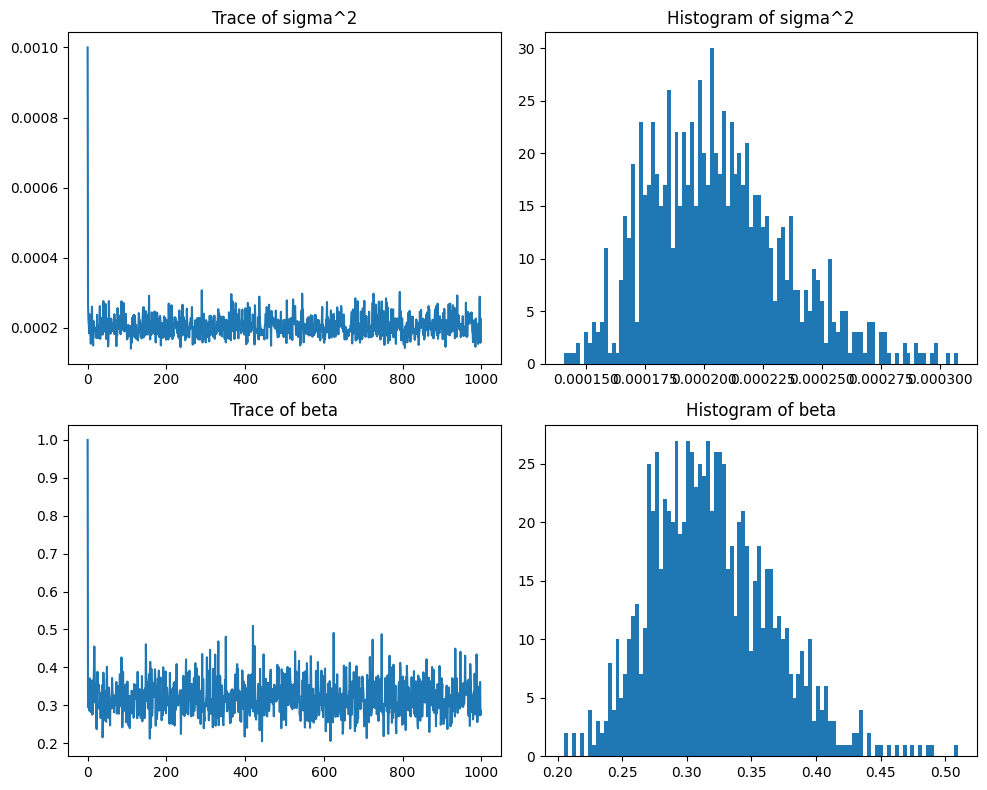

Mean of the likelihoods: 2.9025039015003666


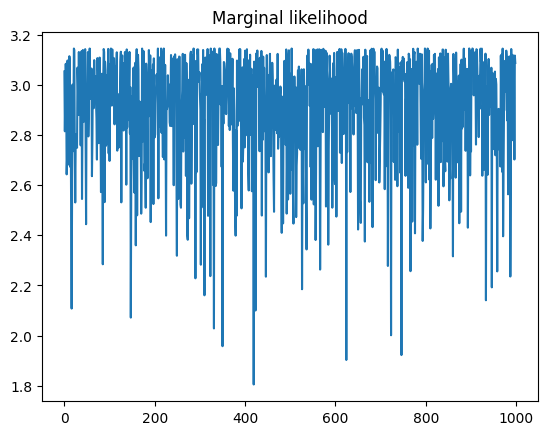

In [237]:


def alpha_xk1(y, beta_param, x_k_1):
    scale = np.sqrt((beta_param**2)*np.exp(x_k_1))
    return norm.pdf(y, 0, scale)

def marginal_likelihood(weights):
    t, k = weights.shape
    prob = []
    for i in range(t):
        prob.append(np.sum(weights[i, :]) / k)
    prob = np.prod(prob)
    return prob

def x1_prior(K, sigma, alpha_param): 
    return np.random.normal(0, (sigma**2 / (1 - alpha_param**2)), K)

def sigma_squared_prior(a,b):
    return invgamma(a, scale=b)

def beta_prior(a,b):
    return invgamma(a, scale=b)

def p_beta_given_x_y(x, y, alpha, beta):
    a_param = alpha + len(x)/2
    b_param = beta + np.sum(np.exp(-x)*y**2)/2

    return invgamma.rvs(a_param, scale=b_param)

def p_sigma_given_alpha_x(alpha_prior, beta_prior, alpha, x):
    a_param = alpha_prior + len(x)/2
    b_param = beta_prior + (x[0]*(1 - alpha_prior**2)/2) + 0.5*np.sum((x[1:] - alpha*x[:-1])**2)
    return invgamma.rvs(a_param, scale=b_param)

def multinomial_resample(weights):
    return np.random.choice(len(weights), size=len(weights), p=weights)

def p_xn_given_xn_minus_1(alpha_param, sigma, xn_minus_1):
    return np.random.normal(alpha_param * xn_minus_1, sigma**2)

def conditional_smc(theta, ref_trajectory, observations, K, PGAS=False):
    alpha, sigma2, beta = theta
    T = len(observations)
    marg_lik = 0.0
    
    particles = np.zeros((T, K))
    importance_weights = np.zeros((T, K))
    normalized_weights = np.zeros((T, K))
    ancestry = np.zeros((T, K), dtype=int)

    particles[:, K-1] = ref_trajectory
    particles[0, 0:K-1] = x1_prior(K-1, sigma2, alpha)
    
    importance_weights[0, :] = alpha_xk1(observations[0], beta, particles[0, :])
    normalized_weights[0, :] = importance_weights[0, :] / np.sum(importance_weights[0, :])
    ancestry[0, :] = np.arange(K)
    marg_lik += np.mean(importance_weights[0, :])
    
    for t in range(1, T):
        sampled_indices = multinomial_resample(normalized_weights[t-1, :])
        new_particles = p_xn_given_xn_minus_1(alpha, sigma2, particles[t-1, sampled_indices])
        
        if PGAS:
            backward_weights = normalized_weights[t-1, :] * norm.pdf(ref_trajectory[t],
                                                                     loc=alpha*particles[t-1,:],
                                                                     scale=np.sqrt(sigma2**2))
            backward_weights = backward_weights / np.sum(backward_weights)
            ref_ancestor = np.random.choice(K, p=backward_weights)
            new_particles[K-1] = ref_trajectory[t]
            sampled_indices[K-1] = ref_ancestor
        else:
            new_particles[K-1] = ref_trajectory[t]
        
        particles[t, :] = new_particles
        importance_weights[t, :] = alpha_xk1(observations[t], beta, particles[t-1, :]) * importance_weights[t-1, sampled_indices]
        ancestry[t, :] = sampled_indices
        normalized_weights[t, :] = importance_weights[t, :] / np.sum(importance_weights[t, :])
        marg_lik += np.mean(importance_weights[t, :])
    
    likelihood = marg_lik
    final_path = np.zeros(T)
    idx = np.random.choice(K, p=normalized_weights[-1, :])
    for t in reversed(range(T)):
        idx = ancestry[t, idx]
        final_path[t] = particles[t, idx]
        
    return final_path, likelihood, particles, ancestry, normalized_weights  

def particle_gibbs(a_prior, b_prior, alpha, T, M, K, observations, PGAS=False, burn_in=10):

    sigma2_current = 0.001
    beta_current = 1.0
    
    x_current = np.zeros((T,M))
    sigma2_trace = np.zeros(M)
    beta_trace = np.zeros(M)
    likelihoods = np.zeros(M-1)
    
    sigma2_trace[0] = sigma2_current
    beta_trace[0] = beta_current
    ref = x1_prior(K, sigma2_current, alpha)
    x_current[:,0] = ref[:T]

    final_particles = None
    final_ancestry = None
    
    for m in range(1,M):
        beta_sample = p_beta_given_x_y(x_current[:,m-1], observations, a_prior, b_prior)
        sigma2_sample = p_sigma_given_alpha_x(a_prior, b_prior, alpha, x_current[:,m-1])
        
        new_ref, likelihood, part_mat, ancestry_mat,normalized_weights = conditional_smc(
            (alpha, sigma2_sample, beta_sample),
            x_current[:,m-1],
            observations,
            K,
            PGAS=PGAS
        )
        
        x_current[:,m] = new_ref
        likelihoods[m-1] = likelihood 
        sigma2_trace[m] = sigma2_sample
        beta_trace[m] = beta_sample
        
        if m == M-1:
            final_particles = part_mat
            final_ancestry = ancestry_mat
    
    sigma2_dist = sigma2_trace[burn_in:]
    beta_dist = beta_trace[burn_in:]
    ref_trajectory = final_particles[:, K-1]
    
    final_trajectory = np.zeros(T)
    idx = np.random.choice(K, p=(normalized_weights[-1, :]))  
    
    for t in reversed(range(T)):
        idx = final_ancestry[t, idx]
        final_trajectory[t] = final_particles[t, idx]

    return sigma2_dist, beta_dist, sigma2_trace, beta_trace, likelihoods, final_trajectory , ref_trajectory , final_particles, final_ancestry



alpha = 0.91
a_prior = 0.01
b_prior = 0.01
observations = np.load('../lab3/observations.npy')
T = len(observations)
M = 1000
K = 100
np.random.seed(111)

sigma2_dist, beta_dist, sigma2_trace, beta_trace, likelihoods, sample_trajectory, ref_trajectory, final_particles, final_ancestry = particle_gibbs(a_prior, b_prior, alpha, T, M, K,observations,PGAS=False, burn_in=100)

print(f"Initial sigma2: {sigma2_trace[0]} Mean of sigma2: {np.mean(sigma2_dist)}")
print(f"Initial beta: {beta_trace[0]} Mean of beta: {np.mean(beta_dist)}")

fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[0,0].plot(sigma2_trace)
axs[0,0].set_title('Trace of sigma^2')
axs[0,1].hist(sigma2_dist, bins=100)
axs[0,1].set_title('Histogram of sigma^2')

axs[1,0].plot(beta_trace)
axs[1,0].set_title('Trace of beta')
axs[1,1].hist(beta_dist, bins=100)
axs[1,1].set_title('Histogram of beta')

plt.tight_layout()
plt.show()

print(f"Mean of the likelihoods: {np.mean(likelihoods)}")

plt.plot(likelihoods)
plt.title('Marginal likelihood')
plt.show()


## **Visualize the path degeneracy**
Using the particle filter from the final MCMC iteration, plot the path degeneracy in the particle filter. Below we provide some code to help you visualize the path degeneracy. 

**Hint:** when you code your BPF, make sure to keep track of the ancestry and the inferred latent states at each time step. I.e. at each time step $n$, book keep the ancestors of the particles in the system, $k$ or $a^k$, and their corresponding $x_n$. This way you can go "backwards in time" and observe the path degeneracy.

(100, 100)
<class 'numpy.ndarray'>


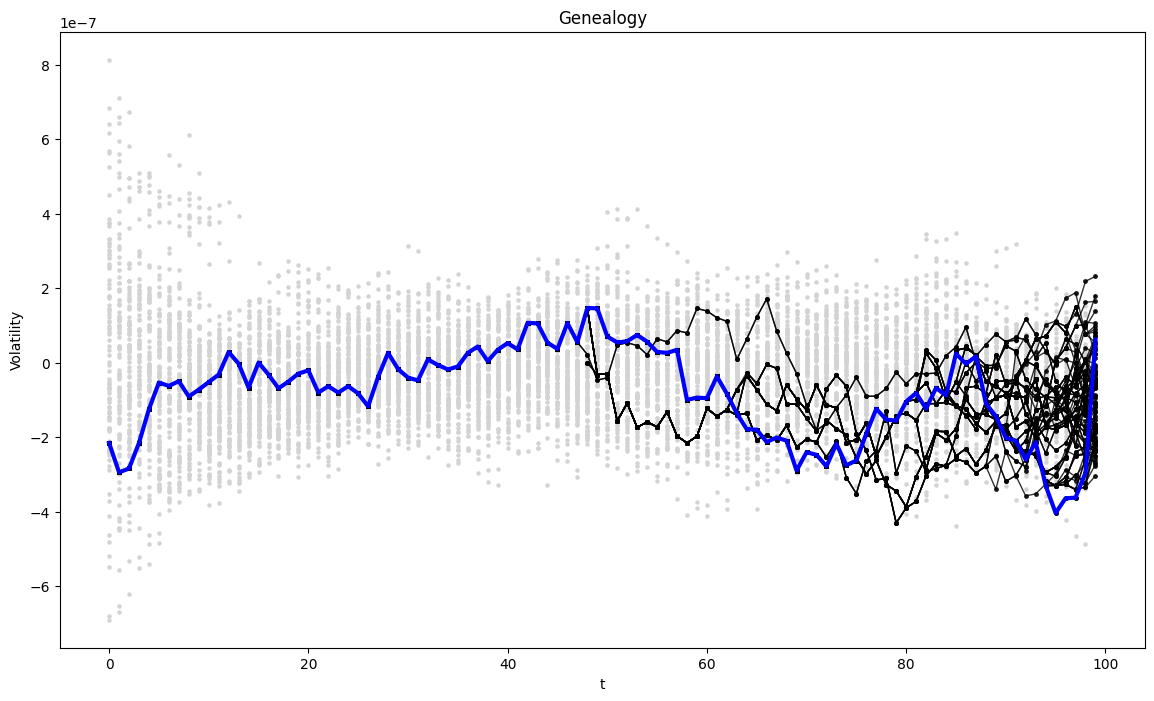

In [238]:
def particleGeneologyAll(title, particles, B, x_true=None, x_rs=None): 
    # particle: the inferred latent states at each time step shape=(num_particles, total_time)
    # B: the complete ancestry shape=(num_particles, total_time)  
    plt.figure(figsize=(14, 8)) 
    N, T = particles.shape 
    x_matrix = np.arange(T)

    # plot all the particles first
    for j in range(N): 
        plt.scatter(x_matrix, particles[j], color="lightgrey", s=5) 
     
    # plot geneology of survived 
    x_star = np.zeros(T) 
    for j in range(N): 
        curr = j 
        i = T-1 
        x_star[i] = particles[j, T-1] 
        for t in reversed(range(T-1)): 
            if curr == N - 1 and j != N - 1: 
                # Originated from reference particle 
                break 
            indx = B[curr, t+1] 
            x_star[i-1] = particles[indx, t] 
            curr = indx 
            i -= 1 
        x_dim = range(t, T) 
         
        if j == N - 1 and x_rs is None: 
            plt.plot(x_dim, x_star, color='blue', linewidth=3) 
        else: 
            plt.plot(x_dim, x_star[t:], color='black', marker='.', markersize=5, lw=1,
                    alpha=0.8, antialiased=True)
     
    if x_rs is not None: 
        for t, resampled, original in zip(range(T), x_rs[0], x_rs[1]): 
            plt.plot((t-1, t), (resampled, original), color='blue', linewidth=3)
     
    if x_true is not None:  
        plt.plot(x_true, color='g', linewidth=3) 
     
    plt.title(title) 
    plt.ylabel('Volatility') 
    plt.xlabel('t') 
    plt.show()
    

print(final_particles.shape)
print(type(final_ancestry))

particleGeneologyAll("Genealogy", final_particles.T, final_ancestry.T)




## **2.2 Implement the Particle Gibbs with Ancestral Sampling (PGAS)**
In "[Particle Gibbs with ancestor sampling](https://www.jmlr.org/papers/volume15/lindsten14a/lindsten14a.pdf)" they point out that the resulting particle system in the PG sampler is undesirably biased towards the reference trajectory. This affects the path degeneracy in the way that most particles are resampled from the reference trajectory.

PGAS is a relatively small update of the PG sampler but comes with great benefits in terms of path degeneracy. Update your PG sampler above into the PGAS, repeat the following two exercises:

*   **Report the approximate marginal likelihood**
*   **Visualize the path degeneracy**



In [239]:
alpha = 0.91
a_prior = 0.01
b_prior = 0.01
observations = np.load('../lab3/observations.npy')
T = len(observations)
M = 1000
K = 100
np.random.seed(111)

#pg
sigma2_dist_pg, beta_dist_pg, sigma2_trace_pg, beta_trace_pg, likelihoods_pg, sample_trajectory_pg, ref_pg, final_particles_pg, final_ancestry_pg = \
    particle_gibbs(a_prior, b_prior, alpha, T, M, K, observations, PGAS=False, burn_in=100)



In [240]:
alpha = 0.91
a_prior = 0.01
b_prior = 0.01
observations = np.load('../lab3/observations.npy')
T = len(observations)
M = 1000
K = 100
np.random.seed(111)

#pgas
sigma2_dist_pgas, beta_dist_pgas, sigma2_trace_pgas, beta_trace_pgas, likelihoods_pgas, sample_trajectory_pgas, ref_pgas, final_particles_pgas, final_ancestry_pgas = \
    particle_gibbs(a_prior, b_prior, alpha, T, M, K, observations, PGAS=True, burn_in=100)

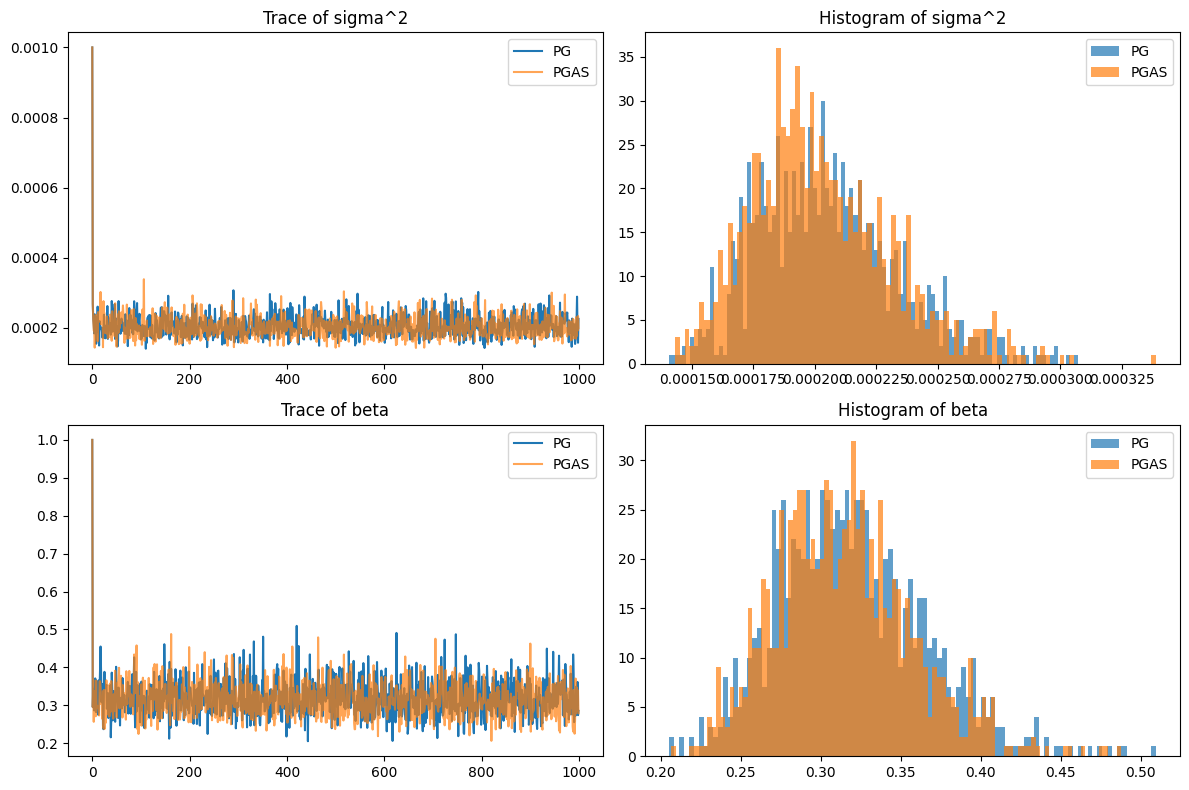

In [241]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].plot(sigma2_trace_pg, label='PG')
axs[0,0].plot(sigma2_trace_pgas, label='PGAS', alpha=0.7)
axs[0,0].set_title('Trace of sigma^2')
axs[0,0].legend()

axs[0,1].hist(sigma2_dist_pg, bins=100, alpha=0.7, label='PG')
axs[0,1].hist(sigma2_dist_pgas, bins=100, alpha=0.7, label='PGAS')
axs[0,1].set_title('Histogram of sigma^2')
axs[0,1].legend()

axs[1,0].plot(beta_trace_pg, label='PG')
axs[1,0].plot(beta_trace_pgas, label='PGAS', alpha=0.7)
axs[1,0].set_title('Trace of beta')
axs[1,0].legend()

axs[1,1].hist(beta_dist_pg, bins=100, alpha=0.7, label='PG')
axs[1,1].hist(beta_dist_pgas, bins=100, alpha=0.7, label='PGAS')
axs[1,1].set_title('Histogram of beta')
axs[1,1].legend()

plt.tight_layout()
plt.show()


Mean likelihood (PG): 2.9025039015003666
Mean likelihood (PGAS): 2.9279737158062935


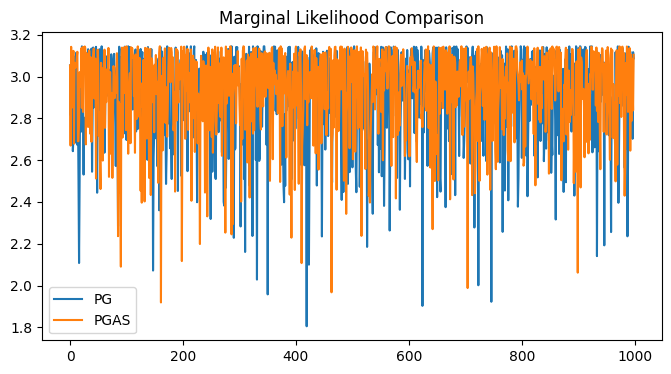

In [242]:
print(f"Mean likelihood (PG): {np.mean(likelihoods_pg)}")
print(f"Mean likelihood (PGAS): {np.mean(likelihoods_pgas)}")

plt.figure(figsize=(8,4))
plt.plot(likelihoods_pg, label='PG')
plt.plot(likelihoods_pgas, label='PGAS')
plt.title('Marginal Likelihood Comparison')
plt.legend()
plt.show()


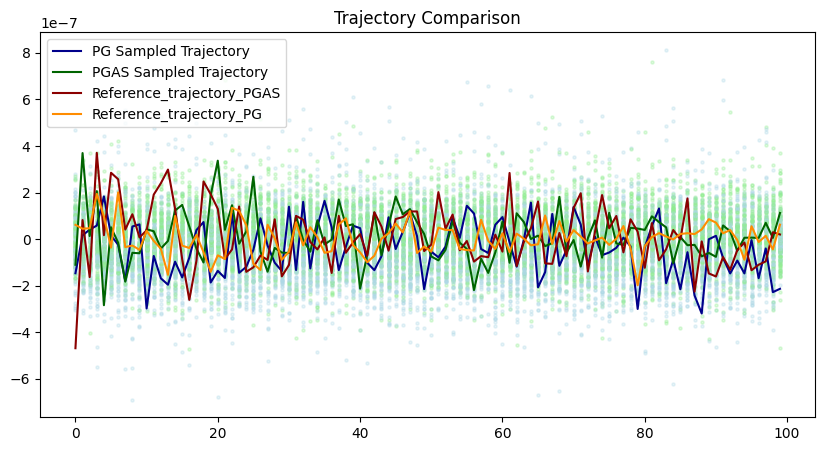

In [243]:
plt.figure(figsize=(10,5))
#plt.plot(ref_trajectory, label='Reference Trajectory', color='blue')
plt.plot(sample_trajectory_pg, label='PG Sampled Trajectory', color='darkblue', alpha=1.0)

plt.plot(sample_trajectory_pgas, label='PGAS Sampled Trajectory', color='darkgreen', alpha=1.0)
plt.plot(ref_pgas, label='Reference_trajectory_PGAS', color='darkred', alpha=1.0)
plt.plot(ref_pg, label='Reference_trajectory_PG', color='darkorange', alpha=1.0)

for k in range(K):
    plt.scatter(range(T), final_particles_pg[k, :], color='lightblue', alpha=0.3, s=5)
    plt.scatter(range(T), final_particles_pgas[k, :], color='lightgreen', alpha=0.3, s=5)

plt.title('Trajectory Comparison')
plt.legend()
plt.show()


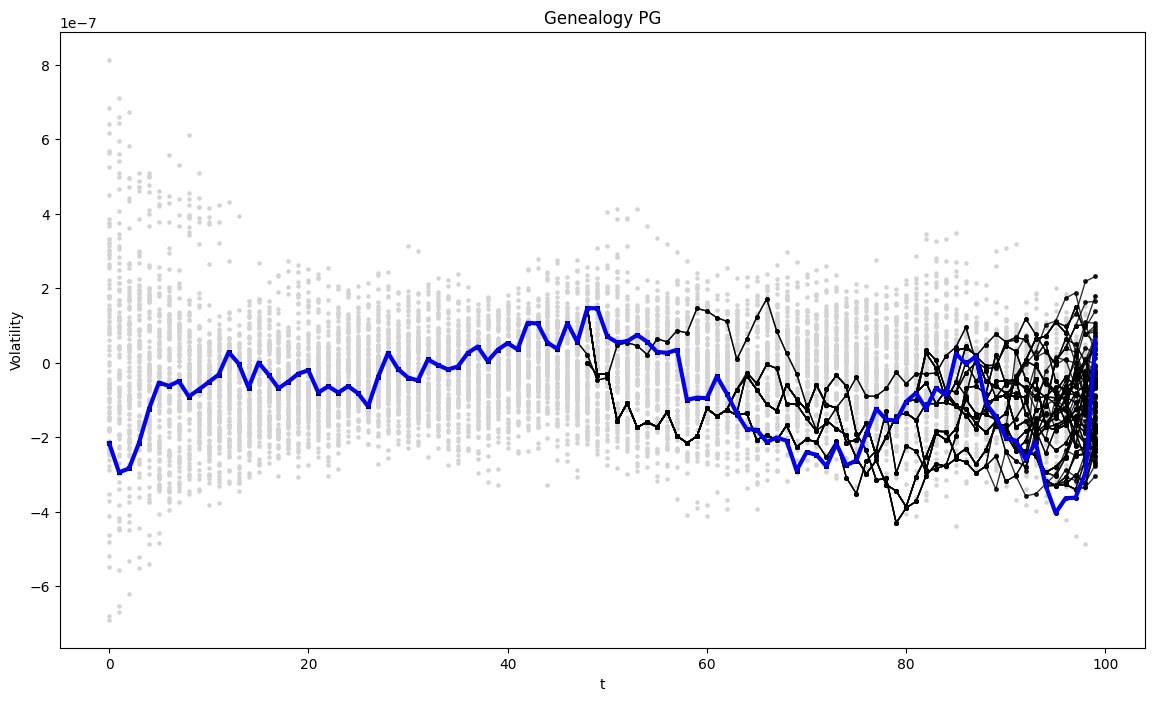

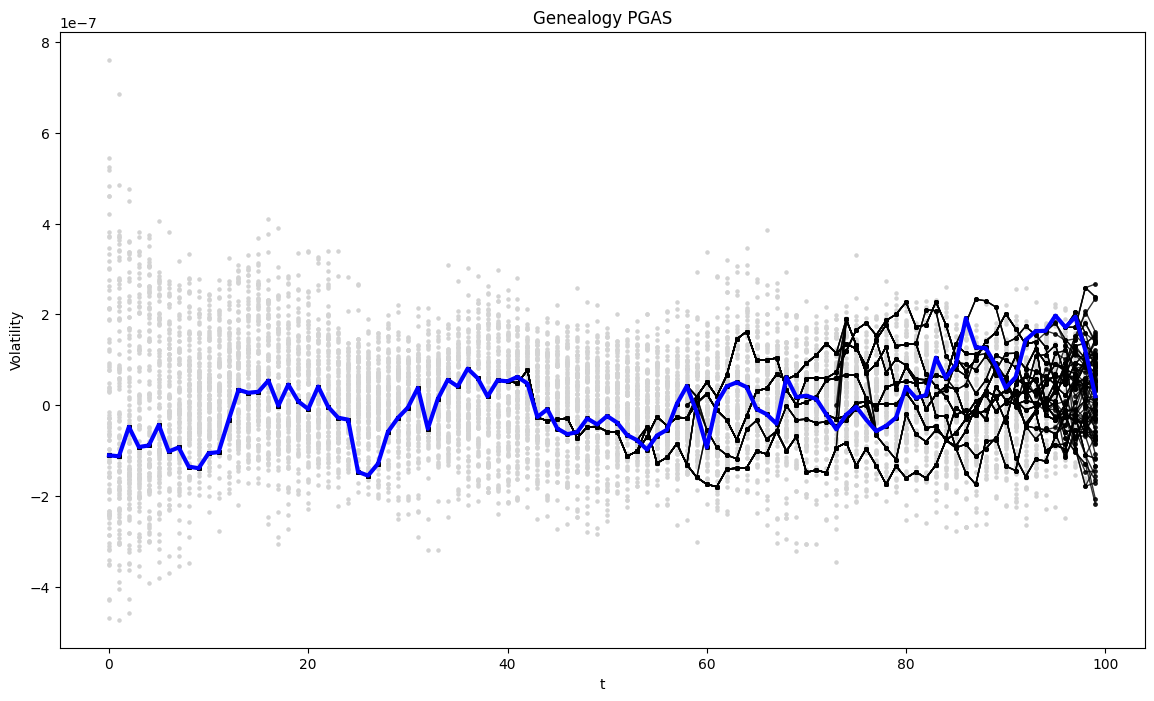

In [244]:

particleGeneologyAll("Genealogy PG", final_particles_pg.T, final_ancestry_pg.T)
particleGeneologyAll("Genealogy PGAS", final_particles_pgas.T, final_ancestry_pgas.T)